## Table of Contents
- [Introduction](#introduction)
- [Import libraries](#libraries)
- [Model training and evaluating functions](#funcs)
- [Data extraction and cleaning](#data_clean)
- [Data analysis](#data_analysis)
- [Data modelling](#data_model)
- [Model analysis](#model_analysis)
- [Conclusion](#conclusion)

## Introduction <a name = "introduction"/>

Diabetes is a condition that arises when your body has an excessively high blood sugar level. In this dataset, we want to analyse what features has a low/high correlation to diabetes, and create a model that can predict well if a patient has diabetes.

The Diabetes prediction dataset contains 100k patients, with 8 features containing patient demographics/past history and the last feature `diabetes` on whether the patient is diagnosed with diabetes. 

The features are as follows:
- `gender`: Patient's gender
    - Female, Male, Other
- `age`: Patient's age
- `hypertension`: Does Patient have a past history of hypertension?
    - 0: Negative, 1: Positive
- `heart_disease`: Does Patient have a past history of heart disease?
    - 0: Negative, 1: Positive
- `smoking_history`: Does Patient smoke?
    - No Info, Current, Ever, Former, Never, Not current
- `bmi`: Patient's Body Mass Index
- `HbA1c_level`: Patient's Hemoglobin A1c
- `blood_glucose_level`: Patient's Blood glucose level
- `diabetes`: Does Patient have diabetes? (Target Feature)

Numerical Features: `age`, `bmi`, `HbA1c_level`, `blood_glucose_level`

Categorical Features: `gender`, `hypertension`, `heart_disease`, `smoking_history`, `diabetes`

https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

## Import libraries <a name = "libraries"/>

In [1]:
# Used for GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
import graphviz
import pydotplus

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.inspection import permutation_importance

## Model training and evaluating functions <a name = "funcs"/>

Below are functions defined in this lab for better notebook readability.

In [3]:
def smoking_history_ohe(row_name, row_sh, ohe_dict):
    ohe_dict["index"].append(row_name)
    
    if row_sh == "No":
        ohe_dict["smoking_history_No"].append(1)
        ohe_dict["smoking_history_Yes"].append(0)
    elif row_sh == "Yes":
        ohe_dict["smoking_history_No"].append(0)
        ohe_dict["smoking_history_Yes"].append(1)
    else:
        ohe_dict["smoking_history_No"].append(0)
        ohe_dict["smoking_history_Yes"].append(0)

In [4]:
def scaling_ohe(data, ss, ss_columns, scale_included = True):
    
    # ohe gender
    data_gender = data["gender"].apply(lambda x: 0 if x == "Female" else 1)
    
    # ohe smoking_history
    ohe_dict = {"index": [], "smoking_history_No": [], "smoking_history_Yes": []}    
    
    data.apply(lambda x: smoking_history_ohe(x.name, x.smoking_history, ohe_dict), axis = 1)
    data_smoking_history = pd.DataFrame.from_dict(ohe_dict).set_index("index")
    
    # Only scale if scale_included = True
    if scale_included:
        # Scaling age, bmi, HbA1c_level, blood_glucose_level
        data_ss = ss.transform(data[ss_columns])
        data_ss = pd.DataFrame(data = data_ss, index = data.index, columns = ss_columns)
        
        data = pd.concat([data_ss, data_gender, data_smoking_history,
                          data["hypertension"], data["heart_disease"]], axis = 1)
        
    else:
        data = pd.concat([data[ss_columns], data_gender, data_smoking_history, 
                          data["hypertension"], data["heart_disease"]], axis = 1)
        
    data = data.reindex(columns = ["gender", "age", "hypertension", "heart_disease", "smoking_history_No", 
               "smoking_history_Yes", "bmi", "HbA1c_level", "blood_glucose_level"])
    
    return data

In [5]:
def eval_model(y_test, y_pred):
    return {
        "auc": roc_auc_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1-score": f1_score(y_test, y_pred)
    }

In [6]:
def plot_coefs_graph(model, plot_title):
    coef_dict = {feature: coef for feature, coef in zip(list(model.feature_names_in_), list(model.coef_[0]))}
    coef_dict = dict(sorted(coef_dict.items(), key = lambda x: x[1]))    
    
    features = list(coef_dict.keys())
    values = list(coef_dict.values())

    fig, ax = plt.subplots(figsize = (10, 5))

    ax = sns.barplot(x = values, y = features, orient = "h")
    ax.set(title = plot_title)

    plt.tight_layout()
    plt.show()
    
    print(coef_dict)

In [7]:
def plot_CM(y_test, y_pred, plot_title):
    fig, ax = plt.subplots()
    
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = "d")
    ax.set(title = plot_title, xlabel = "Predicted", ylabel = "Actual")
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
    
    plt.tight_layout()
    plt.show()

In [8]:
def plot_perm_importances_mean(perm_train, perm_test, col_list, plot_title):    
    perm_train_dict = {col: imp_mean for col, imp_mean in zip(col_list, perm_train["importances_mean"])}
    perm_test_dict = {col: imp_mean for col, imp_mean in zip(col_list, perm_test["importances_mean"])}
    
    d = {"train set": perm_train_dict, "test set": perm_test_dict}
    
    pd.DataFrame(d).plot(kind = "bar")
    plt.title(plot_title)
    
    plt.show()
    
    print()
    
    print(f"train importances mean: {perm_train['importances_mean']}")
    print(f"test importances mean: {perm_test['importances_mean']}")

## Data extraction and cleaning <a name = "data_clean"/>

In [9]:
diab_df = pd.read_csv("diabetes_prediction_dataset.csv")

In [10]:
diab_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [11]:
diab_df.shape

(100000, 9)

In [12]:
diab_df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [13]:
for col in diab_df.columns:
    print(f"{col}")
    print(diab_df[col].value_counts().sort_index())
    
    print()

gender
Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

age
0.08       36
0.16       59
0.24       87
0.32       89
0.40       66
         ... 
76.00     733
77.00     730
78.00     682
79.00     621
80.00    5621
Name: age, Length: 102, dtype: int64

hypertension
0    92515
1     7485
Name: hypertension, dtype: int64

heart_disease
0    96058
1     3942
Name: heart_disease, dtype: int64

smoking_history
No Info        35816
current         9286
ever            4004
former          9352
never          35095
not current     6447
Name: smoking_history, dtype: int64

bmi
10.01    2
10.08    1
10.14    1
10.19    1
10.21    1
        ..
88.72    1
88.76    1
91.82    1
95.22    1
95.69    1
Name: bmi, Length: 4247, dtype: int64

HbA1c_level
3.5    7662
4.0    7542
4.5    7585
4.8    7597
5.0    7471
5.7    8413
5.8    8321
6.0    8295
6.1    8048
6.2    8269
6.5    8362
6.6    8540
6.8     642
7.0     634
7.5     643
8.2     661
8.8     661
9.0     654
Name: HbA1

In [14]:
diab_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

There are no features with null values

## Data analysis <a name = "data_analysis"/>

In [15]:
numerical_features = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
categorical_features = ["gender", "hypertension", "heart_disease", "smoking_history"]
target_feature = ["diabetes"]

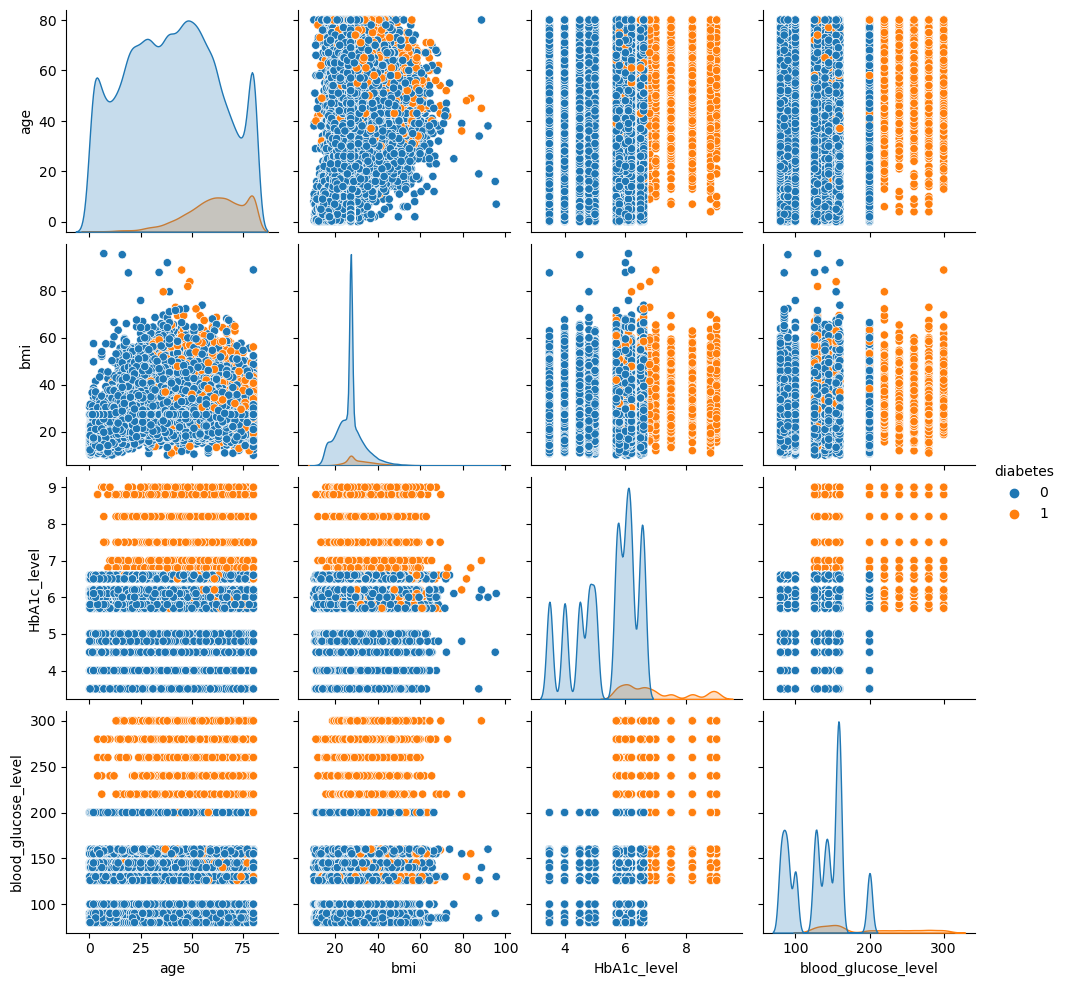

In [16]:
sns.pairplot(data = diab_df.loc[:, numerical_features + target_feature], hue = "diabetes")

Based on numerical features, patients who have diabetes:
- are generally older (Age vs Diabetes)
- have a higher Hemoglobin A1C level (HbA1c_level vs Diabetes)
- have a higher Blood glucose level (blood_glucose_level vs Diabetes)
- are on the higher end of BMI (BMI vs Diabetes)

Modelling
- The numerical features do not have a normal distribution
    - Scaling is required during modelling

We can see there are many different results in smoking history with somewhat similar in meaning. We are going to recategorise them into the following groups:

- `Yes`: Patient has smoked before
    - Includes the following categories: `current`, `not current`, `ever`, `former`
- `No`: Patient has never smoked
    - Includes the following categories: `never`
- `Not Applicable`: No Info
    - Includes the following categories: `No Info`

In [17]:
diab_df["smoking_history"].value_counts()

No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking_history, dtype: int64

In [18]:
diab_df["smoking_history"] = diab_df["smoking_history"].replace({
    "No Info": "Not Applicable",
    "never": "No",
    "current": "Yes",
    "not current": "Yes",
    "ever": "Yes",
    "former": "Yes",
})

In [19]:
diab_df["smoking_history"].value_counts()

Not Applicable    35816
No                35095
Yes               29089
Name: smoking_history, dtype: int64

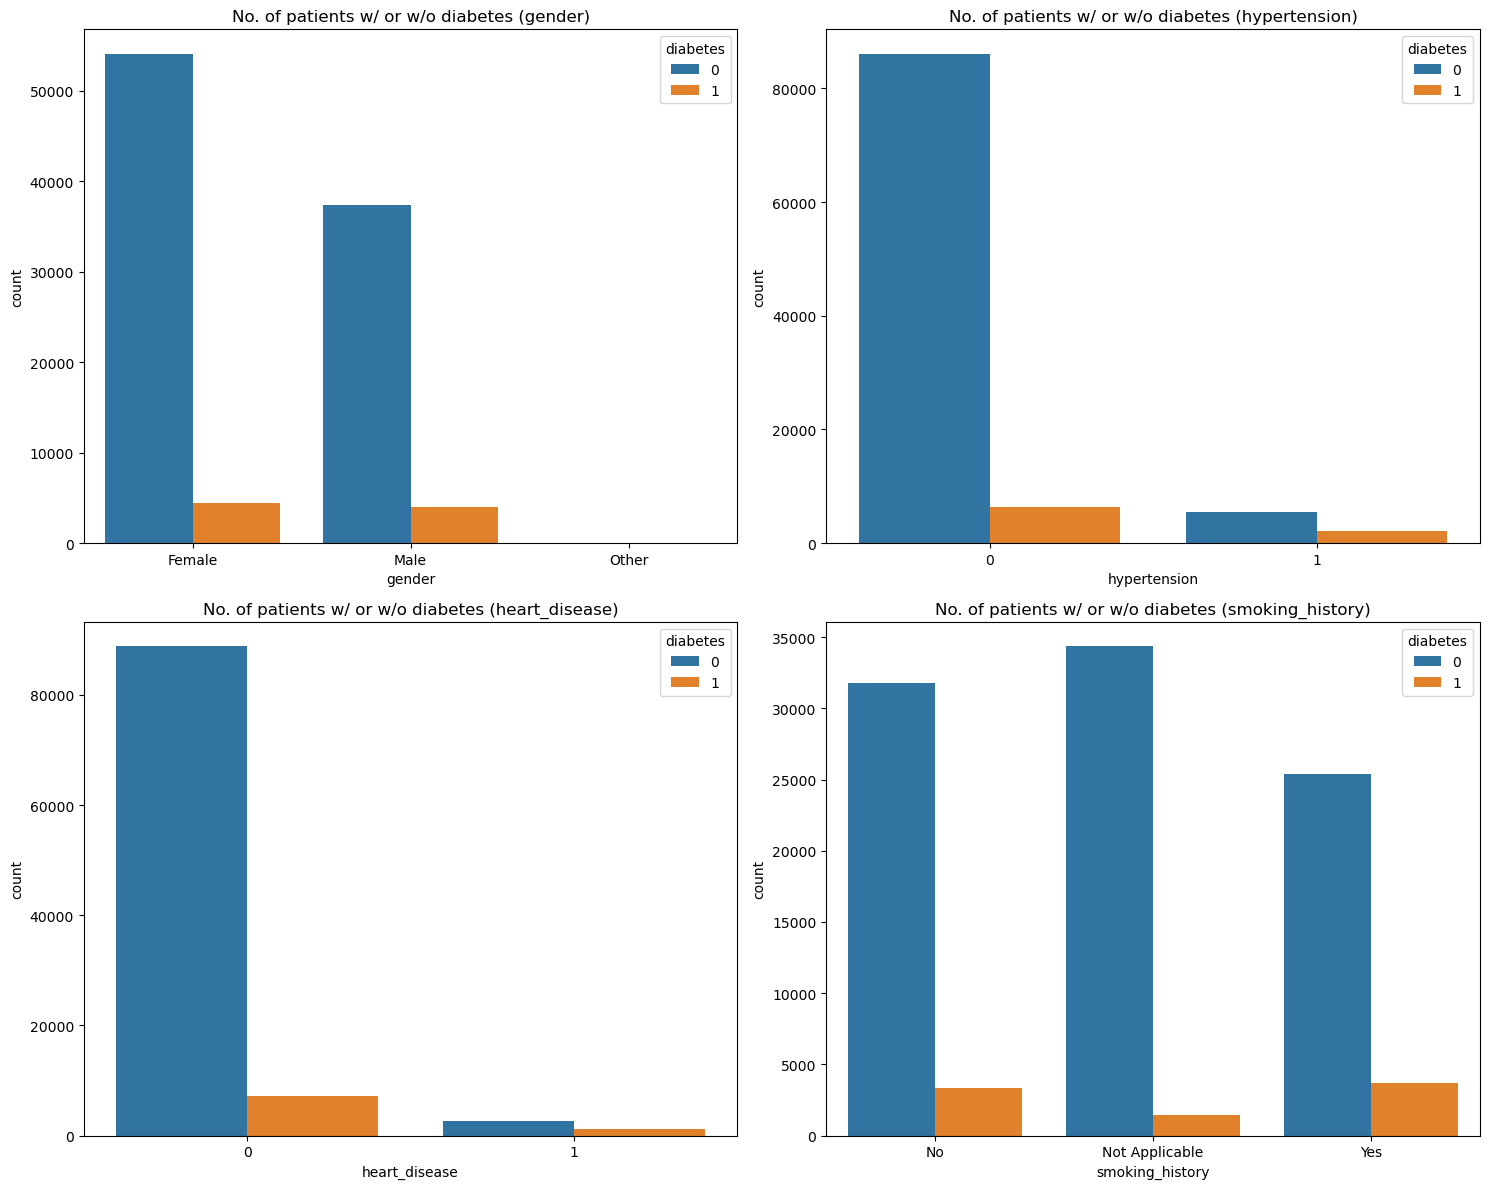

In [20]:
fig, axList = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 12))

axList = axList.flatten()

for ax, col in zip(axList, categorical_features):
    sns.countplot(data = diab_df, x = col, hue = "diabetes", ax = ax)
    ax.set_title(f"No. of patients w/ or w/o diabetes ({col})")
    
plt.tight_layout()

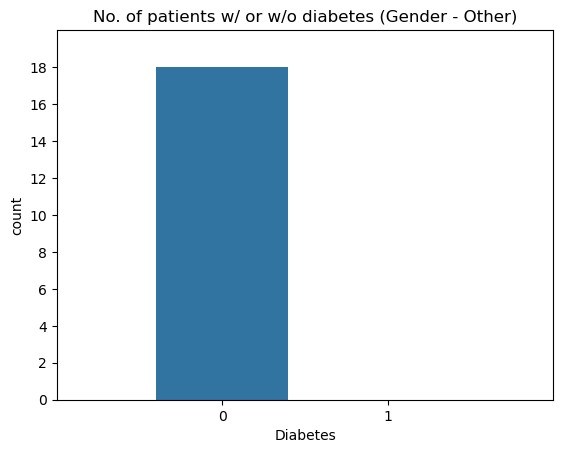

In [21]:
# Extra plot generated for Gender - Other, as previous plot could not show it clearly
fig, ax = plt.subplots()

ax = sns.countplot(data = diab_df[diab_df["gender"] == "Other"], x = "gender", hue = "diabetes")
ax.set(title = "No. of patients w/ or w/o diabetes (Gender - Other)",
       xlabel = "Diabetes", xlim = [-1, 2], xticks = [0, 1], xticklabels = [0, 1], 
       ylim = [0, 20], yticks = range(0, 20, 2))

ax.legend().set_visible(False)
plt.show()

Based on categorical features, patients who have diabetes:
- have a past medical history of hypertension and heart disease
- are smokers or past smokers
- are male (over female/Other)

As we see above, patients who are less healthy and with past medical history are more likely to be diagnosed with diabetes.

However, does age and gender play a role in being diagnosed with diabetes? Lets analyse the ages and genders with the other features

Lets start with numerical features.

First we create a list that contains the range limit for each feature, to be used in the plots. The range will be from the minimum to the maximum value

In [22]:
for col in numerical_features:
    print(f"{col} min: {diab_df[col].min()}, {col} max: {diab_df[col].max()}")

age min: 0.08, age max: 80.0
bmi min: 10.01, bmi max: 95.69
HbA1c_level min: 3.5, HbA1c_level max: 9.0
blood_glucose_level min: 80, blood_glucose_level max: 300


In [23]:
numerical_features_lim = {
    'age_lim': [-5, 85],
    'bmi_lim': [5, 100],
    'HbA1c_level_lim': [0, 10],
    'blood_glucose_level_lim': [75, 305]
}

In [24]:
# Splitting dataset into negative and positive diabetic patients
non_diab_pat_df = diab_df[diab_df["diabetes"] == 0]
diab_pat_df = diab_df[diab_df["diabetes"] == 1]

We will be using 2 separate plots for `age` and `gender`

- As `age` is a numerical feature, we can use lineplots to show the different values as a person ages
- As `gender` is a categorical feature, we can use boxplots to show the different values for different genders

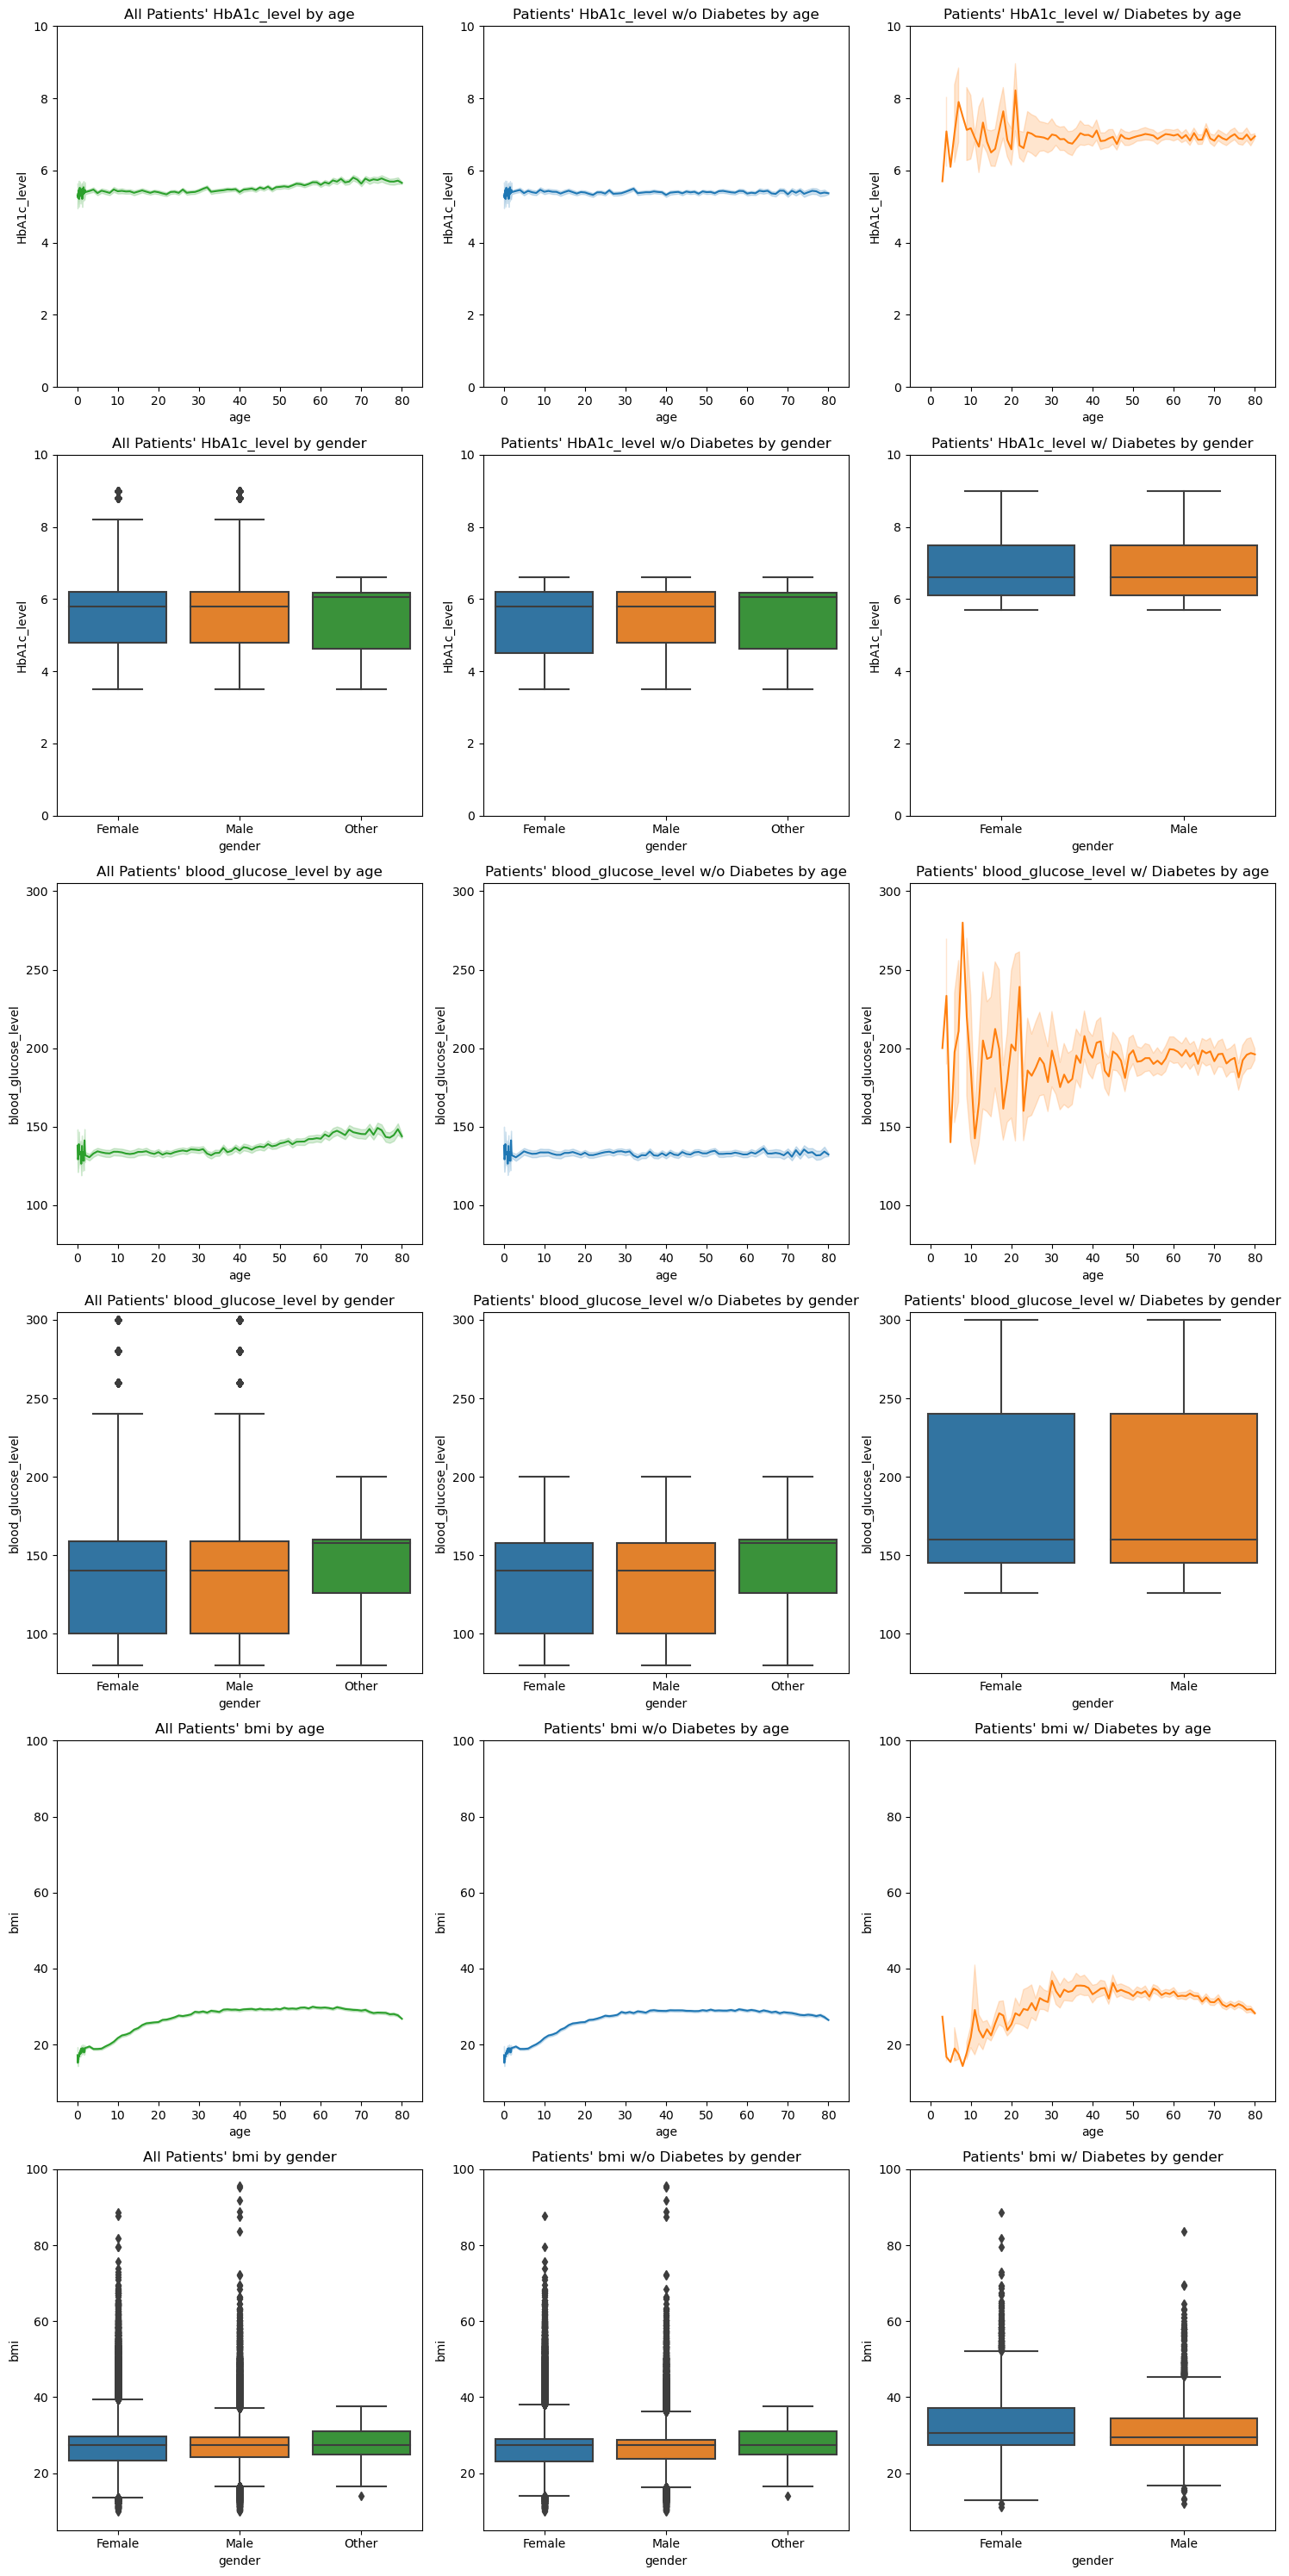

In [25]:
fig, axList = plt.subplots(nrows = 6, ncols = 3, figsize = (15, 30))

axList = np.reshape(axList, (3, 6))

for axRow, col in zip(axList, ["HbA1c_level", "blood_glucose_level", "bmi"]):
    ax_age_orig, ax_age_0, ax_age_1 = axRow[0], axRow[1], axRow[2]
    ax_gender_orig, ax_gender_0, ax_gender_1 = axRow[3], axRow[4], axRow[5]
    
    # Age
    
    sns.lineplot(data = diab_df, x = "age", y = col, estimator = np.mean, color = "tab:green", ax = ax_age_orig)
    ax_age_orig.set(title = f"All Patients' {col} by age",
                    xlim = numerical_features_lim["age_lim"], 
                    ylim = numerical_features_lim[f"{col}_lim"])
    
    sns.lineplot(data = non_diab_pat_df, x = "age", y = col, estimator = np.mean, color = "tab:blue",  ax = ax_age_0)
    ax_age_0.set(title = f"Patients' {col} w/o Diabetes by age",
                 xlim = ax_age_orig.get_xlim(),
                 ylim = ax_age_orig.get_ylim())

    sns.lineplot(data = diab_pat_df, x = "age", y = col, estimator = np.mean, color = "tab:orange",  ax = ax_age_1)
    ax_age_1.set(title = f"Patients' {col} w/ Diabetes by age",
                 xlim = ax_age_orig.get_xlim(), 
                 ylim = ax_age_orig.get_ylim())
    
    # Gender
    
    sns.boxplot(data = diab_df, x = "gender", y = col, ax = ax_gender_orig)
    ax_gender_orig.set(title = f"All Patients' {col} by gender",
                       ylim = numerical_features_lim[f"{col}_lim"])
        
    sns.boxplot(data = non_diab_pat_df, x = "gender", y = col, ax = ax_gender_0)
    ax_gender_0.set(title = f"Patients' {col} w/o Diabetes by gender",
                    ylim = ax_gender_orig.get_ylim())

    sns.boxplot(data = diab_pat_df, x = "gender", y = col, ax = ax_gender_1)
    ax_gender_1.set(title = f"Patients' {col} w/ Diabetes by gender",
                    ylim = ax_gender_orig.get_ylim())

plt.tight_layout()

- Gender does not have distinct differences for `bmi`, `HbA1c_level` and `blood_glucose_level` as the trends of boxplot are similar
- `bmi` tends to have an increase and slight decrease trend with `age`, while `HbA1c_level` and `blood_glucose_level` has a slight increasing trend with `age`
- There is a lot of variance in data for the younger patients, but in general, we can still see that diabetic patients tend to have a higher `bmi`, `HbA1c_level` and `blood_glucose_level`

As we recall earlier with the unique values of each feature, while the data in `HbA1c_level` and `blood_glucose_level` is numerical data, it is less continuous, but partitioned into numerical categories

We will be using boxplot for each numerical partitioned category to see if we can display a similar or concrete plot that shows the two levels increasing with `age`.

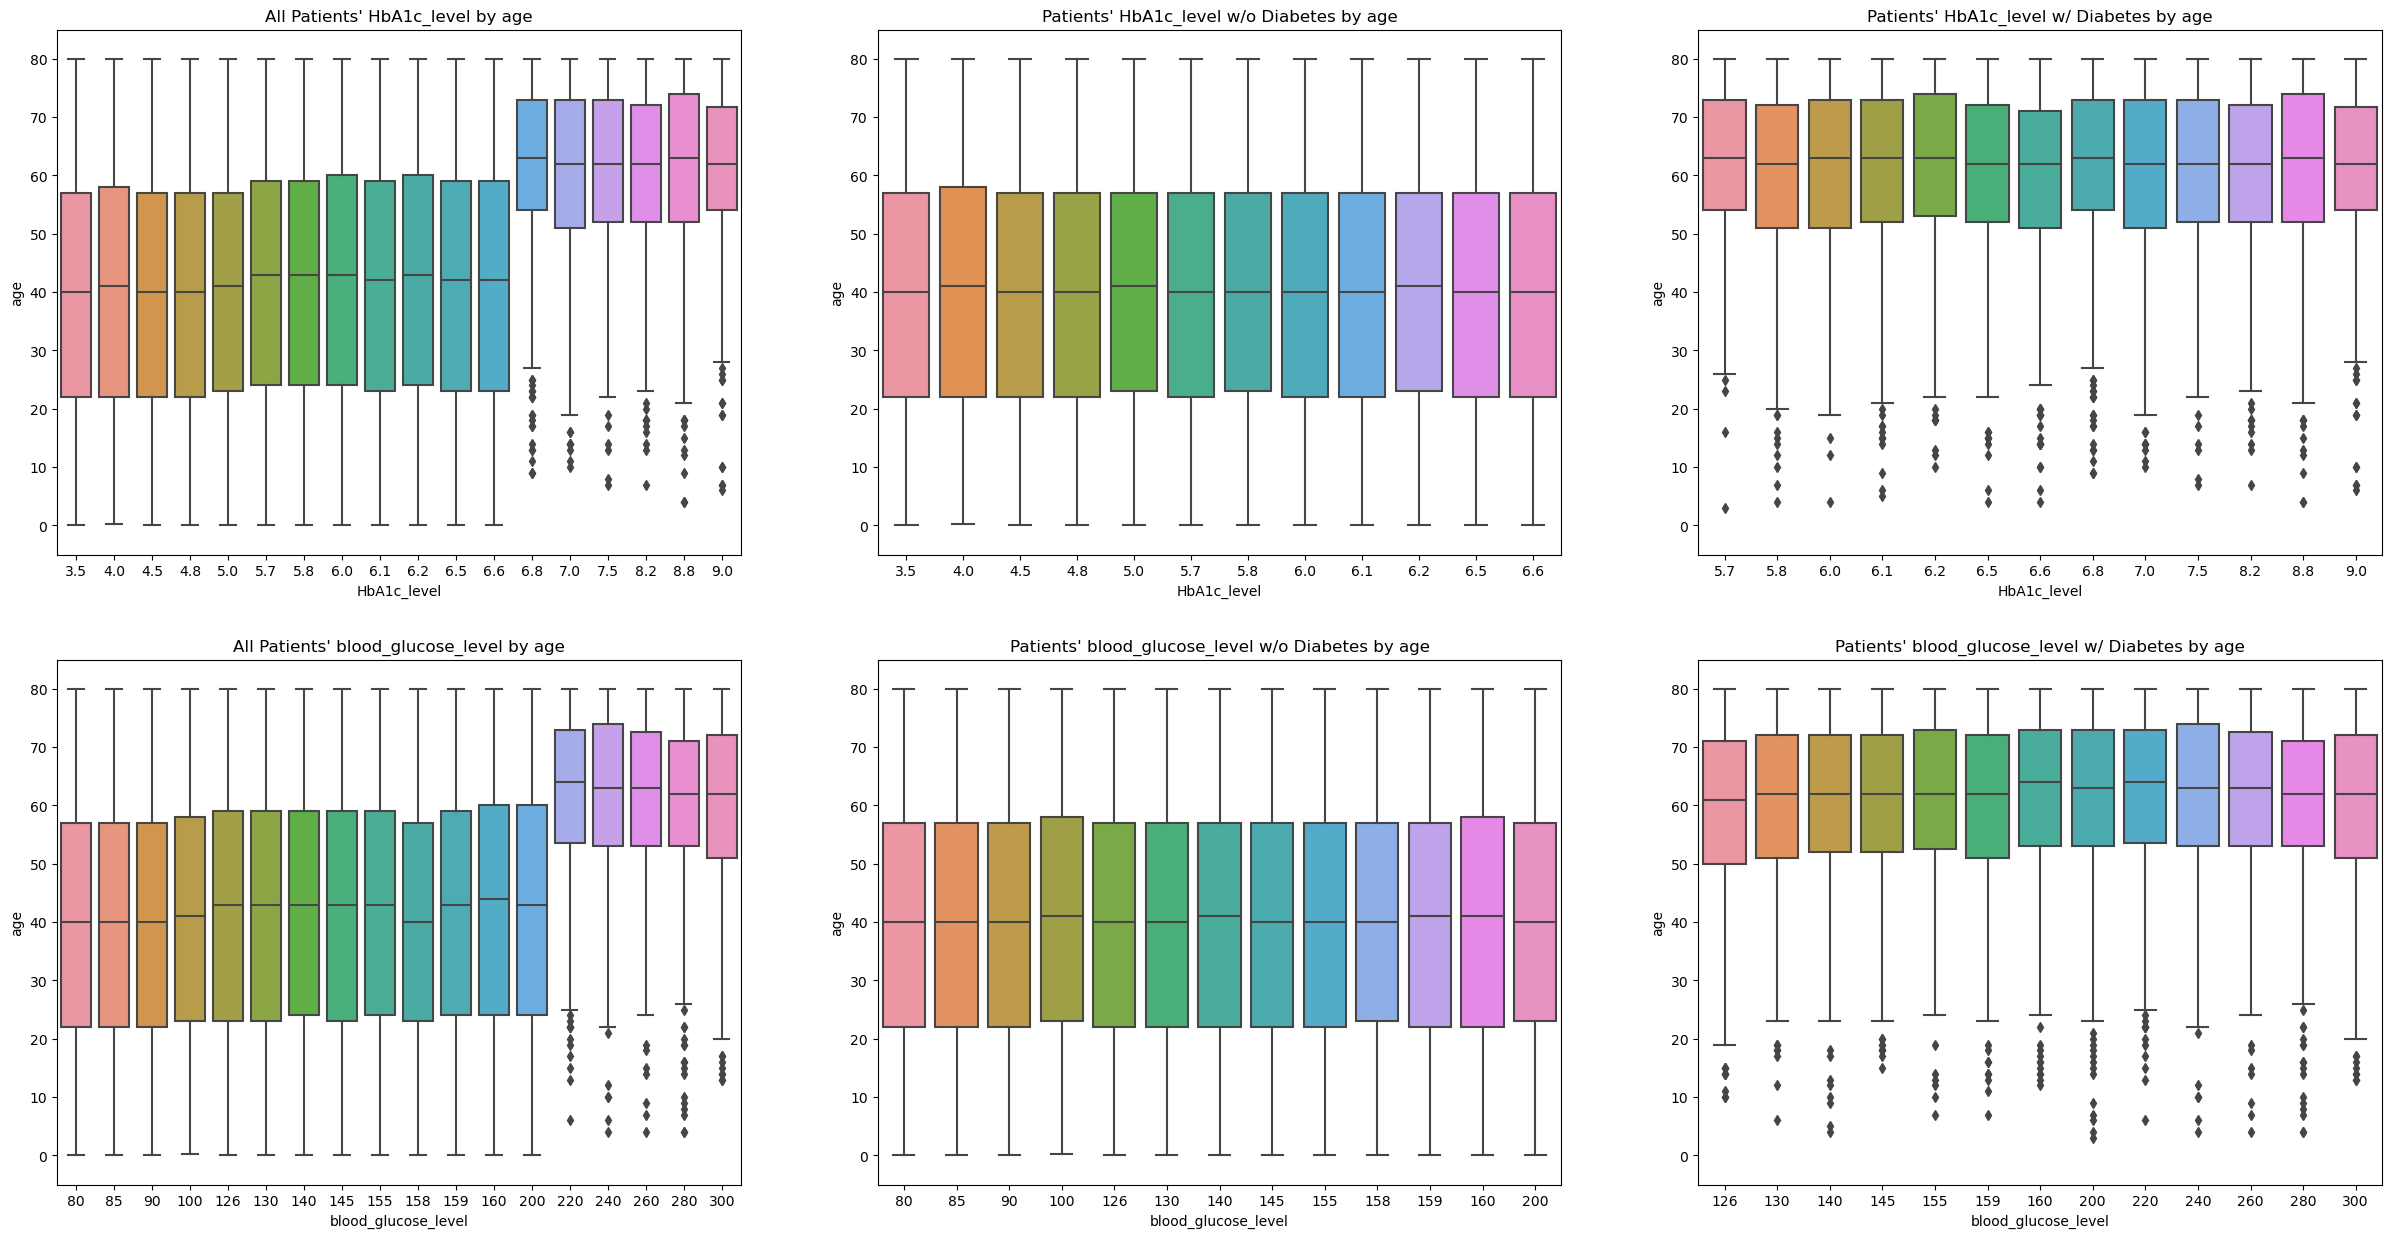

In [26]:
fig, axList = plt.subplots(nrows = 2, ncols = 3, figsize = (30, 15))

for axRow, col in zip(axList, ["HbA1c_level", "blood_glucose_level"]):
    ax_col_orig, ax_col_0, ax_col_1 = axRow[0], axRow[1], axRow[2]
    
    sns.boxplot(data = diab_df, x = col, y = "age", ax = ax_col_orig)
    ax_col_orig.set(title = f"All Patients' {col} by age",
                    ylim = numerical_features_lim[f"age_lim"])
        
    sns.boxplot(data = non_diab_pat_df, x = col, y = "age", ax = ax_col_0)
    ax_col_0.set(title = f"Patients' {col} w/o Diabetes by age",
                    ylim = ax_col_orig.get_ylim())

    sns.boxplot(data = diab_pat_df, x = col, y = "age", ax = ax_col_1)
    ax_col_1.set(title = f"Patients' {col} w/ Diabetes by age",
                    ylim = ax_col_orig.get_ylim())

We also create a histogram plot to visualise if there is any imbalanced data of age

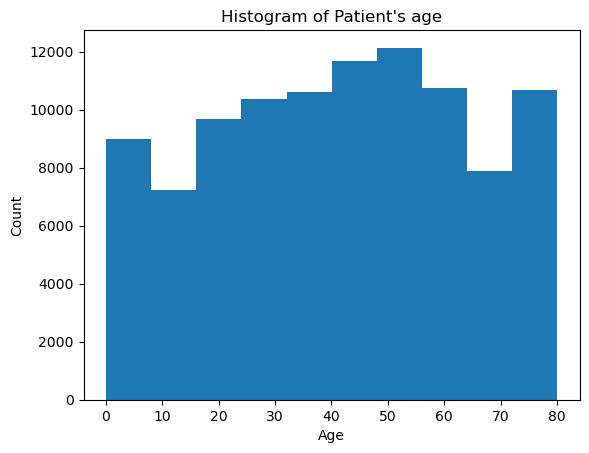

In [27]:
diab_df["age"].plot.hist()

plt.title("Histogram of Patient's age")
plt.xlabel("Age")
plt.ylabel("Count")

plt.show()

- Patients that are diabetic tend to be around the ages of 50 to 75 with a `HbA1c_level` and `blood_glucose_level`
- Based on the histogram, the number of patients taken on all ages is relatively similar.

Now we look at the categorical features.

We will also be using 2 separate plots for `age` and `gender`

- As `age` is a numerical feature, we can use boxplots to show the different value and age ranges for each feature's unique value
- As `gender` is a categorical feature, we can use countplot to classify each feature's unique value based on their gender

In [28]:
# Setting colours for plot
categorical_features_palette = {
    "hypertension_palette": {0: "tab:blue", 1: "darkorange"},
    "heart_disease_palette": {0: "tab:blue", 1: "darkorange"},
    "smoking_history_palette": {"No": "tab:blue", "Yes": "darkorange", "Not Applicable": "green"}
}

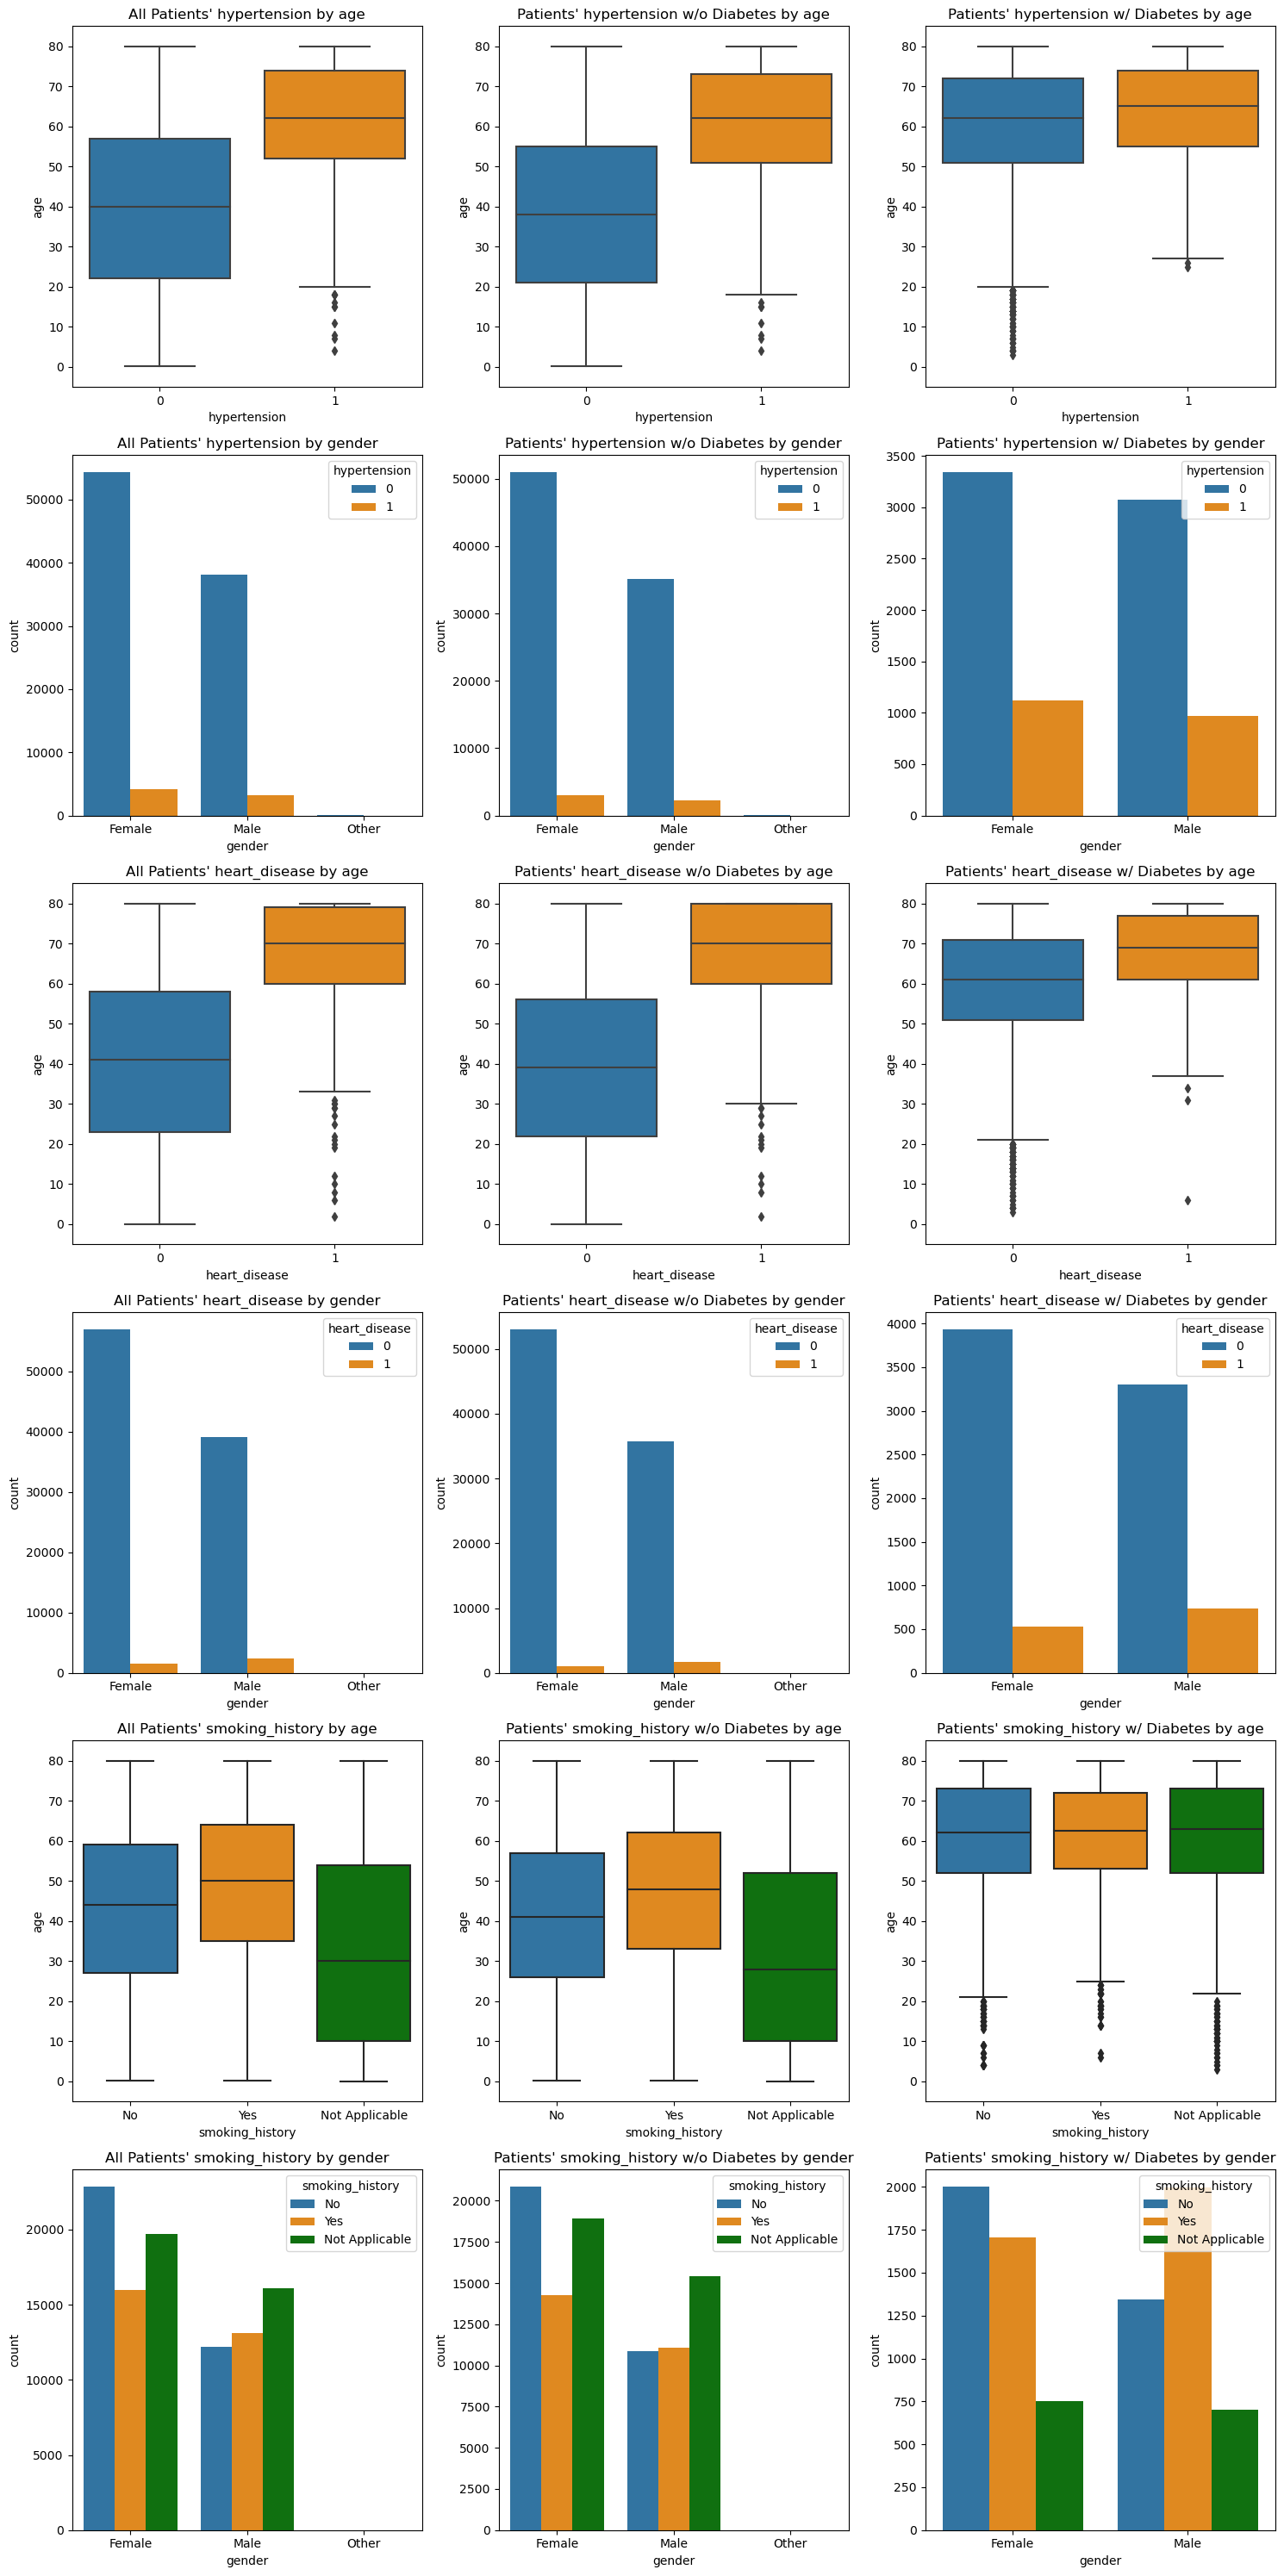

In [29]:
fig, axList = plt.subplots(nrows = 6, ncols = 3, figsize = (15, 30))

axList = np.reshape(axList, (3, 6))

for axRow, col in zip(axList, ["hypertension", "heart_disease", "smoking_history"]):
    ax_age_orig, ax_age_0, ax_age_1 = axRow[0], axRow[1], axRow[2]
    ax_gender_orig, ax_gender_0, ax_gender_1 = axRow[3], axRow[4], axRow[5]
    
    # Age
    
    sns.boxplot(data = diab_df, x = col, y = "age",
                palette = categorical_features_palette[f"{col}_palette"], 
                order = ["No", "Yes", "Not Applicable"] if col == "smoking_history" else [0, 1],
                ax = ax_age_orig)
    ax_age_orig.set(title = f"All Patients' {col} by age",
                    ylim = numerical_features_lim["age_lim"])

    sns.boxplot(data = non_diab_pat_df, x = col, y = "age",
                palette = categorical_features_palette[f"{col}_palette"], 
                order = ["No", "Yes", "Not Applicable"] if col == "smoking_history" else [0, 1],
                ax = ax_age_0)
    ax_age_0.set(title = f"Patients' {col} w/o Diabetes by age",
                 ylim = ax_age_orig.get_ylim())

    sns.boxplot(data = diab_pat_df, x = col, y = "age",
                palette = categorical_features_palette[f"{col}_palette"],
                order = ["No", "Yes", "Not Applicable"] if col == "smoking_history" else [0, 1],
                ax = ax_age_1)
    ax_age_1.set(title = f"Patients' {col} w/ Diabetes by age",
                 ylim = ax_age_orig.get_ylim())
        
    # Gender
    
    sns.countplot(data = diab_df, x = "gender", hue = col,
                  palette = categorical_features_palette[f"{col}_palette"],
                  hue_order = ["No", "Yes", "Not Applicable"] if col == "smoking_history" else [0, 1],
                  ax = ax_gender_orig)
    ax_gender_orig.set(title = f"All Patients' {col} by gender")
    
    sns.countplot(data = non_diab_pat_df, x = "gender", hue = col,
                  palette = categorical_features_palette[f"{col}_palette"],
                  hue_order = ["No", "Yes", "Not Applicable"] if col == "smoking_history" else [0, 1],
                  ax = ax_gender_0)
    ax_gender_0.set(title = f"Patients' {col} w/o Diabetes by gender")

    sns.countplot(data = diab_pat_df, x = "gender", hue = col,
                  palette = categorical_features_palette[f"{col}_palette"],
                  hue_order = ["No", "Yes", "Not Applicable"] if col == "smoking_history" else [0, 1],
                  ax = ax_gender_1)
    ax_gender_1.set(title = f"Patients' {col} w/ Diabetes by gender")

plt.tight_layout()

- Both Female and Male patients are equally likely to be diagnosed with `hypertension` and `heart disease`
- Patients whose `age` are in the range of 50 to 75 are more commonly seen to have `hypertension, heart disease and diabetes`
- The average `age` and range of patients who smoke are older
- However, there is a vast majority of patients who prefer not to share their `smoking history`, with most being males that may range from a younger age.
- Male patients were found to be past/current smokers than female patients
- Analysis for the `gender = Other` has been left out as there isnt enough information to prove a relationship

## Data modelling <a name = "data_model"/>

Step-by-step Modelling
- Preprocessing/Feature engineering
    - Scaling & One-hot encoding
        - Numerical features will be scaled using `StandardScaler`
            - `age`, `bmi`, `HbA1c_level` and `blood_glucose_level`
            - Note: Data does not require scaling when using `Decision Trees`
        - Categorical features will be splited using `One-hot encoding`
            - `gender`, `smoking_history`
            - `hypertension` and `heart_disease` is already divided into the 2 classes, and will not undergo any changes        
    - Resampling
        - The following techniques are used to tackle imbalanced data:
            - `Oversampling`
                - Increasing the number of samples to match the majority class
            - `Undersampling`
                - Reducing the number of samples to match the minority class
            - `Class Reweighting`
                - Adjusting the class weights in the model
    - L1 Regularization
        - Based on the number of features, we can conduct feature selection and select relevant features for the model. This will also be useful during model analysis
- Modelling and scoring
    - We will be creating 3 different models:
        - `Logistic Regression`
        - `Support Vector Machines`
        - `Decision Trees`
    - `GridSearchCV` will be used for cross validation and finding best model parameters
    - And finally evaluate which technique works best for our dataset with:
        - `AUC`
        - `Precision`
        - `Recall`
            - We will be putting more emphaise on `recall` as we want to be sure of detecting positive diabetic cases
        - `F1-score`
    - Finally, we will analyse best models presented

Lets analyse the `diabetes` feature for any imbalanced data and split it

0    0.915
1    0.085
Name: diabetes, dtype: float64


<Axes: >

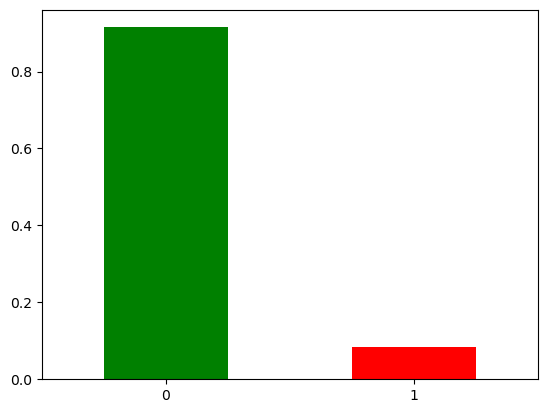

In [30]:
print(diab_df["diabetes"].value_counts(normalize = True))
diab_df["diabetes"].value_counts(normalize = True).plot(kind = "bar", color = ["green", "red"], rot = 0)

We can see that the dataset has an imbalanced data.
- 91.5% negative cases (majority class)
- 8.05% positive cases (minority class)

If we use the original dataset, the model would be heavily bias towards the majority class due to the overwhelming number of data. We will need to perform imbalanced data techniques to balance both classes so that the model can learn both sides of cases.

If you recall, there were only 18 instances of patients whose genders are Other. Since Other is a extremely tiny subset of the dataset, and is also part of the majority class, we can remove it to reduce the number of different genders in the dataset for the model to train on.

In [31]:
diab_df = diab_df.drop(diab_df[diab_df["gender"] == "Other"].index, axis = 0)

In [32]:
diab_df.shape

(99982, 9)

Before resampling, we have to split the data. We will use `stratify = y` to ensure that the ratio of the number of classes in `diabetes` is the same for both train and test set

In [33]:
x = diab_df.drop("diabetes", axis = 1)
y = diab_df["diabetes"]

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 0)

In [35]:
# See split shape
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(79985, 8) (19997, 8) (79985,) (19997,)


In [36]:
# See stratifying
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

0    0.914984
1    0.085016
Name: diabetes, dtype: float64
0    0.914987
1    0.085013
Name: diabetes, dtype: float64


### Scaling/One-hot encoding features

Scaling
- numerical_features: "age", "bmi", "HbA1c_level", "blood_glucose_level"

We will be using `StandardScaler` to scale the numerical features

In [37]:
ss_columns = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]

ss = StandardScaler()
x_train_ss = ss.fit_transform(x_train[ss_columns])

In [38]:
x_train_ss = pd.DataFrame(data = x_train_ss, index = x_train.index, columns = ss_columns)

In [39]:
x_train_ss.head()

,age,bmi,HbA1c_level,blood_glucose_level
68845,1.469197,-7.711617e-07,0.253718,-0.295494
58152,-0.929125,5.265405e-02,-1.894063,1.519889
53707,-0.085271,-7.711617e-07,1.000772,1.519889
83248,1.247130,2.106116e-02,3.241935,0.170618
75166,-0.040857,-7.711617e-07,-0.680100,-0.933331


One-hot encoding
- categorical_features: "gender", "smoking_history"

As `gender` is a binary category after removing `gender = Other`, we can perform the changes using pandas
- `gender`
    - `Female` = 0
    - `Male` = 1

In [40]:
# Before change
x_train[["gender"]].head()

,gender
68845,Female
58152,Female
53707,Male
83248,Male
75166,Female


In [41]:
x_train_gender = x_train["gender"].apply(lambda x: 0 if x == "Female" else 1)

In [42]:
# After change
x_train_gender.head()

68845    0
58152    0
53707    1
83248    1
75166    0
Name: gender, dtype: int64

`smoking_history` contains 3 values - `No`, `Yes`, `Not Applicable`. 

We will be using pandas to perform One-hot encoding. There will be only 2 columns in the end - `smoking_history_No` and `smoking_history_Yes`. 

For patients who are `Not Applicable`, both columns will be 0.

In [43]:
# Before change
x_train[["smoking_history"]].head()

,smoking_history
68845,Yes
58152,No
53707,No
83248,No
75166,Not Applicable


In [44]:
ohe_dict = {"index": [], "smoking_history_No": [], "smoking_history_Yes": []}

x_train.apply(lambda x: smoking_history_ohe(x.name, x.smoking_history, ohe_dict), axis = 1)
x_train_smoking_history = pd.DataFrame.from_dict(ohe_dict).set_index("index")

In [45]:
# After change
x_train_smoking_history.head()

,smoking_history_No,smoking_history_Yes
index,,
68845,0,1
58152,1,0
53707,1,0
83248,1,0
75166,0,0


In [46]:
x_train_sohe = pd.concat([x_train_ss, x_train_gender, x_train_smoking_history, 
                            x_train["hypertension"], x_train["heart_disease"]], axis = 1).reindex(
    columns = ["gender", "age", "hypertension", "heart_disease", "smoking_history_No", 
               "smoking_history_Yes", "bmi", "HbA1c_level", "blood_glucose_level"])

x_train_sohe.head()

,gender,age,hypertension,heart_disease,smoking_history_No,smoking_history_Yes,bmi,HbA1c_level,blood_glucose_level
68845,0,1.469197,0,0,0,1,-7.711617e-07,0.253718,-0.295494
58152,0,-0.929125,0,0,1,0,5.265405e-02,-1.894063,1.519889
53707,1,-0.085271,0,0,1,0,-7.711617e-07,1.000772,1.519889
83248,1,1.247130,0,0,1,0,2.106116e-02,3.241935,0.170618
75166,0,-0.040857,0,0,0,0,-7.711617e-07,-0.680100,-0.933331


In [47]:
# Check if scaling and ohe may have caused NaN values
x_train_sohe.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history_No     0
smoking_history_Yes    0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
dtype: int64

Time to do the same for `x_test`

In [48]:
# Before
x_test.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
13129,Female,28.0,0,0,Yes,30.93,5.7,145
26040,Female,34.0,0,0,No,43.23,4.0,158
23373,Female,61.0,1,0,No,26.89,4.5,158
89174,Male,28.0,0,0,No,37.18,5.8,200
98043,Female,43.0,0,0,No,35.25,4.8,130


In [49]:
x_test_sohe = scaling_ohe(data = x_test, ss = ss, ss_columns = ["age", "bmi", "HbA1c_level", "blood_glucose_level"])

In [50]:
# After
x_test_sohe.head()

,gender,age,hypertension,heart_disease,smoking_history_No,smoking_history_Yes,bmi,HbA1c_level,blood_glucose_level
13129,0,-0.618231,0,0,0,1,0.543096,0.160336,0.170618
26040,0,-0.351751,0,0,1,0,2.393537,-1.427154,0.489536
23373,0,0.847410,1,0,1,0,-0.064691,-0.960245,0.489536
89174,1,-0.618231,0,0,1,0,1.483361,0.253718,1.519889
98043,0,0.047969,0,0,1,0,1.193007,-0.680100,-0.197365


### Resampling

We will be using a default representation of `Logistic Regression` (i.e. not finding best hyperparameters values), and train it with the 3 different resampling methods `Oversampling`, `Undersampling` and `Class Reweighting` to see which resampling technique works best

Using `SMOTE` for `Oversampling`

In [51]:
smote = SMOTE(random_state = 0)
x_smote, y_smote = smote.fit_resample(x_train_sohe, y_train)

In [52]:
y_smote.value_counts()

0    73185
1    73185
Name: diabetes, dtype: int64

Using `RandomUnderSampler` for `Undersampling`

In [53]:
rus = RandomUnderSampler(random_state = 0)
x_rus, y_rus = rus.fit_resample(x_train_sohe, y_train)

In [54]:
y_rus.value_counts()

0    6800
1    6800
Name: diabetes, dtype: int64

Using `class reweighting`

Since there are 91.5% negative and 8.5% positive cases, we will increase the weight of positive cases while reducing the weight of negative cases

In [55]:
y_train.value_counts(normalize = True)

0    0.914984
1    0.085016
Name: diabetes, dtype: float64

In [56]:
class_weight = {0: 0.085, 1: 0.915}

Create evaluation for `y_test` and `y_pred`

In [57]:
resampling_eval_df = pd.DataFrame(columns = ["Sampling Technique", "auc", "precision", "recall", "f1-score"])

for sampling_technique in ["no resampling", "oversampling", "undersampling", "class reweighting"]:
    # Running Logistic Regression
    lr = LogisticRegression(max_iter = 1000, random_state = 0,
                            class_weight = class_weight if sampling_technique == "class reweighting" else None)
    
    if sampling_technique == "oversampling":    
        lr.fit(x_smote, y_smote)
    elif sampling_technique == "undersampling":
        lr.fit(x_rus, y_rus)
    elif sampling_technique == "no resampling" or sampling_technique == "class reweighting":
        lr.fit(x_train_sohe, y_train)
        
    # Evaluating results and saving it in DataFrame for analysis
    eval_results = eval_model(y_test, lr.predict(x_test_sohe))
    
    new_row = pd.DataFrame({
        "Sampling Technique": sampling_technique,
        "auc": eval_results["auc"],
        "precision": eval_results["precision"],
        "recall": eval_results["recall"],
        "f1-score": eval_results["f1-score"]
    }, index = [0])    
    
    resampling_eval_df = pd.concat([resampling_eval_df, new_row]).reset_index(drop = True)
    
    
resampling_eval_df

,Sampling Technique,auc,precision,recall,f1-score
0,no resampling,0.806031,0.871181,0.620588,0.724837
1,oversampling,0.887132,0.427839,0.884118,0.576635
2,undersampling,0.887665,0.427922,0.885294,0.576960
3,class reweighting,0.888636,0.429957,0.886471,0.579059


- With no change in data, it had a high precision of `87.1%` but average recall of `62.1%`
- As we want to ensure that the model can detect positive cases well, we will choose sampling techniques over none to increase the weightage the minority class (positive cases) has on the model
    - `class reweighting` will be the sampling technqiue as it has the highest `auc`, `precision`, `recall`, and `f1-score`

### Feature selection

We will be using a heatmap for a quick analysis on the correlations between all features

In [58]:
train_set = pd.concat([x_train_sohe, y_train], axis = 1)
train_set.head()

,gender,age,hypertension,heart_disease,smoking_history_No,smoking_history_Yes,bmi,HbA1c_level,blood_glucose_level,diabetes
68845,0,1.469197,0,0,0,1,-7.711617e-07,0.253718,-0.295494,0
58152,0,-0.929125,0,0,1,0,5.265405e-02,-1.894063,1.519889,0
53707,1,-0.085271,0,0,1,0,-7.711617e-07,1.000772,1.519889,0
83248,1,1.247130,0,0,1,0,2.106116e-02,3.241935,0.170618,1
75166,0,-0.040857,0,0,0,0,-7.711617e-07,-0.680100,-0.933331,0


In [59]:
print(train_set.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history_No     0
smoking_history_Yes    0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


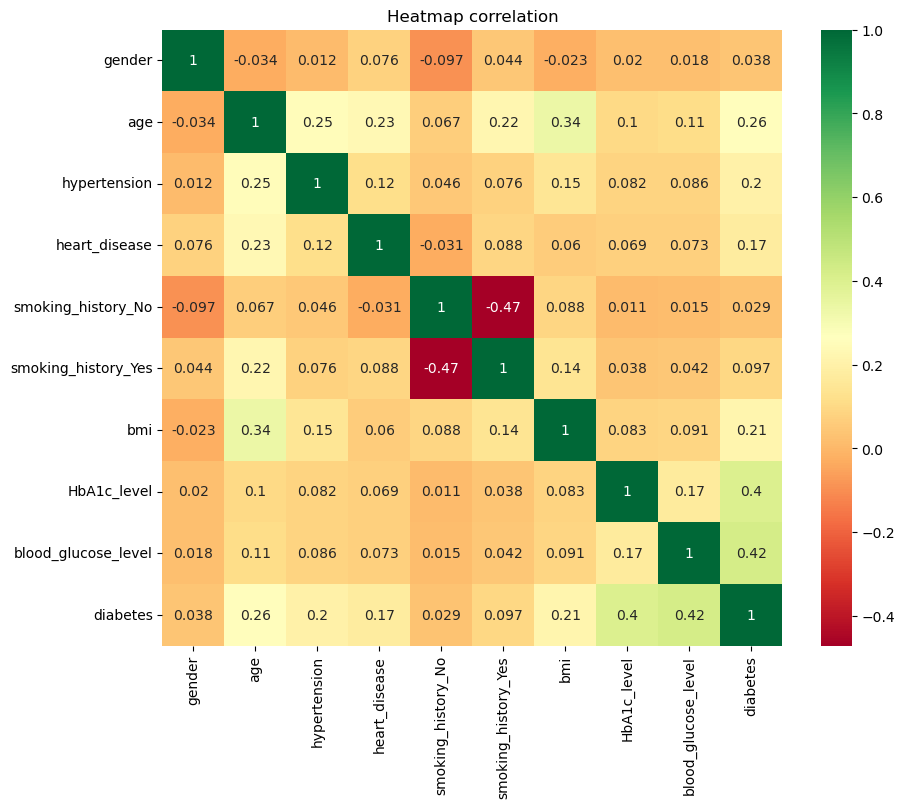

In [60]:
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.heatmap(train_set.corr(), annot = True, cmap = "RdYlGn")

ax.set(title = "Heatmap correlation")

plt.show()

- Features like `gender` and `smoking_history` are the lowest in correlation while `HbA1c_level` and `blood_glucose_level` are the highest in correlation to `diabetes`

Lets analyse which features are useful and not useful to train the models. We will be using `L1 Regularisation` as it introduces a penalty based on the values of the coefficients. Features that are unable to explain well will have coefficients set to zero

In [61]:
lr = LogisticRegression(solver = "liblinear",max_iter = 1000, random_state = 0, class_weight = class_weight)
lr.fit(x_train_sohe, y_train)

LogisticRegression(class_weight={0: 0.085, 1: 0.915}, max_iter=1000,
                   random_state=0, solver='liblinear')

In [62]:
lr_l1 = LogisticRegression(penalty = "l1", solver = "liblinear",max_iter = 1000, random_state = 0, class_weight = class_weight)
lr_l1.fit(x_train_sohe, y_train)

LogisticRegression(class_weight={0: 0.085, 1: 0.915}, max_iter=1000,
                   penalty='l1', random_state=0, solver='liblinear')

In [63]:
list(lr.coef_[0])

[0.30259718358738596,
 1.0785022408322147,
 0.830095992771275,
 0.796585722667546,
 0.570210706118586,
 0.64248891413752,
 0.6280021879523606,
 2.283146463258862,
 1.2705874076610748]

In [64]:
list(lr.feature_names_in_)

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'smoking_history_No',
 'smoking_history_Yes',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level']

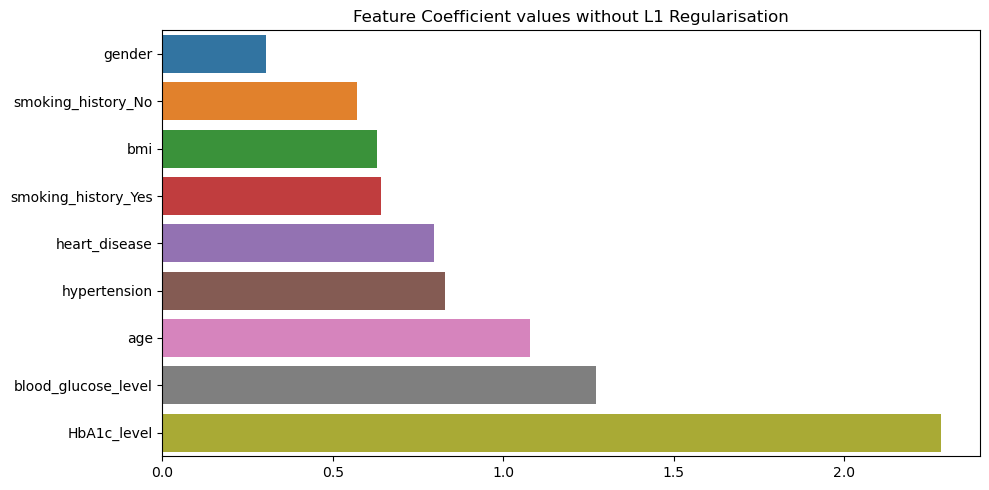

{'gender': 0.30259718358738596, 'smoking_history_No': 0.570210706118586, 'bmi': 0.6280021879523606, 'smoking_history_Yes': 0.64248891413752, 'heart_disease': 0.796585722667546, 'hypertension': 0.830095992771275, 'age': 1.0785022408322147, 'blood_glucose_level': 1.2705874076610748, 'HbA1c_level': 2.283146463258862}


In [65]:
plot_coefs_graph(lr, plot_title = "Feature Coefficient values without L1 Regularisation")

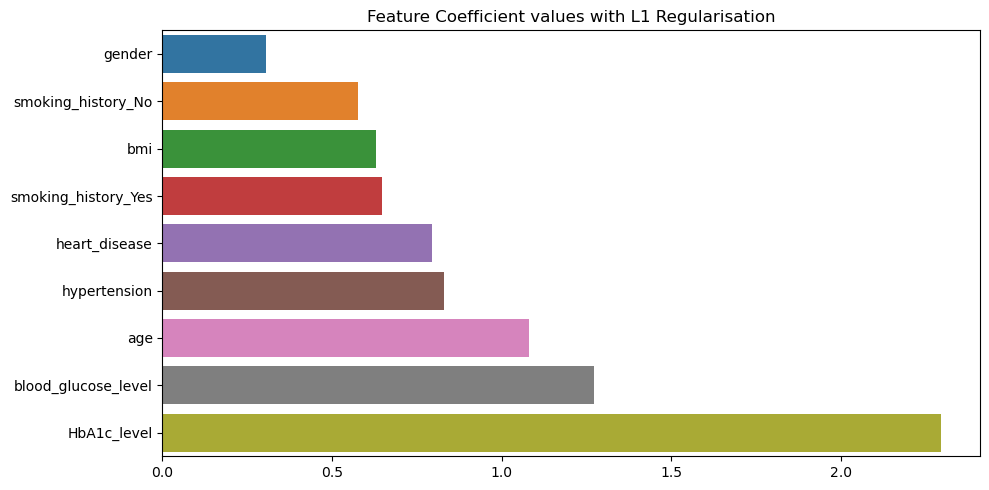

{'gender': 0.30469608212719435, 'smoking_history_No': 0.5768931349277336, 'bmi': 0.6294348253533175, 'smoking_history_Yes': 0.6489957416358015, 'heart_disease': 0.7955045633106959, 'hypertension': 0.8312533363848895, 'age': 1.0824718786675747, 'blood_glucose_level': 1.273916256214475, 'HbA1c_level': 2.295946159007623}


In [66]:
plot_coefs_graph(lr_l1, plot_title = "Feature Coefficient values with L1 Regularisation")

Functions used to analyse coefficient values

- All features show a positive correlation to `diabetes`
- `HbA1c_level` has the highest correlation to `diabetes`, while `gender` has the least correlation
- `l1` penalty did not make much difference
- As no features are dropped to zero with `l1` penalty, all features are assumed to have an impact on the model.

### Modelling

#### Logistic Regression

In [67]:
lr_param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2", "elasticnet"],
    "solver": ["lbfgs", "liblinear", "newton-cholesky", "saga"],
    "l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9]
}

lr_grid_search = GridSearchCV(LogisticRegression(max_iter = 1000, random_state = 0, class_weight = class_weight),
                              param_grid = lr_param_grid, scoring = "f1", cv = 5, verbose  = 2)
lr_grid_search.fit(x_train_sohe, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END .....C=0.01, l1_ratio=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, l1_ratio=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, l1_ratio=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, l1_ratio=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, l1_ratio=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, l1_ratio=0.1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, l1_ratio=0.1, penalty=l1, solver=newton-cholesky; total time=   0.0s
[CV] END C=0.01, l1_ratio=0.1, penalty=l

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={0: 0.085, 1: 0.915},
                                          max_iter=1000, random_state=0),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cholesky',
                                    'saga']},
             scoring='f1', verbose=2)

In [68]:
print(lr_grid_search.best_params_)

lr_best = lr_grid_search.best_estimator_
lr_best.fit(x_train_sohe, y_train)

print(eval_model(y_test, lr_best.predict(x_test_sohe)))

{'C': 0.01, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
{'auc': 0.8871526351153676, 'precision': 0.4267877412031782, 'recall': 0.8847058823529412, 'f1-score': 0.5758039816232772}


#### SVM

In [69]:
svm_param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"]
}

svm_grid_search = GridSearchCV(SVC(max_iter = 1000, random_state = 0, class_weight = class_weight),
                              param_grid = svm_param_grid, scoring = "f1", cv = 5, verbose  = 2)
svm_grid_search.fit(x_train_sohe, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.7s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.6s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   2.9s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   2.8s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   2.8s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   2.7s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   2.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   5.3s
[CV] END .....................C=0.1, gamma=scal

GridSearchCV(cv=5,
             estimator=SVC(class_weight={0: 0.085, 1: 0.915}, max_iter=1000,
                           random_state=0),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1', verbose=2)

In [70]:
print(svm_grid_search.best_params_)

svm_best = svm_grid_search.best_estimator_
svm_best.fit(x_train_sohe, y_train)

print(eval_model(y_test, svm_best.predict(x_test_sohe)))

{'C': 10, 'gamma': 'auto', 'kernel': 'sigmoid'}
{'auc': 0.7886399731232057, 'precision': 0.2988095238095238, 'recall': 0.7382352941176471, 'f1-score': 0.42542372881355933}


#### Decision Trees

In [71]:
x_train.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
68845,Female,75.0,0,0,Yes,27.32,5.8,126
58152,Female,21.0,0,0,No,27.67,3.5,200
53707,Male,40.0,0,0,No,27.32,6.6,200
83248,Male,70.0,0,0,No,27.46,9.0,145
75166,Female,41.0,0,0,Not Applicable,27.32,4.8,100


A slight touch has to be done to the feature set. Categorical features (i.e. `gender`, `smoking_history`) has to be encoded into numbers as Decision Tree is unable to take in string values.

The function `scaling_ohe()` has a parameter `scale_included` that we can use to not scale our numerical features

In [72]:
x_train_ohe = scaling_ohe(x_train, ss = None, ss_columns = ss_columns, scale_included = False)
display(x_train_ohe.head())
print(x_train_ohe.isnull().sum())

print()

x_test_ohe = scaling_ohe(x_test, ss = None, ss_columns = ss_columns, scale_included = False)
display(x_test_ohe.head())
print(x_test_ohe.isnull().sum())

,gender,age,hypertension,heart_disease,smoking_history_No,smoking_history_Yes,bmi,HbA1c_level,blood_glucose_level
68845,0,75.0,0,0,0,1,27.32,5.8,126
58152,0,21.0,0,0,1,0,27.67,3.5,200
53707,1,40.0,0,0,1,0,27.32,6.6,200
83248,1,70.0,0,0,1,0,27.46,9.0,145
75166,0,41.0,0,0,0,0,27.32,4.8,100


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history_No     0
smoking_history_Yes    0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
dtype: int64



,gender,age,hypertension,heart_disease,smoking_history_No,smoking_history_Yes,bmi,HbA1c_level,blood_glucose_level
13129,0,28.0,0,0,0,1,30.93,5.7,145
26040,0,34.0,0,0,1,0,43.23,4.0,158
23373,0,61.0,1,0,1,0,26.89,4.5,158
89174,1,28.0,0,0,1,0,37.18,5.8,200
98043,0,43.0,0,0,1,0,35.25,4.8,130


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history_No     0
smoking_history_Yes    0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
dtype: int64


In [73]:
dt_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 20, 30, 40, 50],
    "min_samples_split": [10, 20, 50, 100, 1000],
    "min_samples_leaf": [10, 20, 50, 100, 1000],
    "max_features": ["sqrt", "log2"]
}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 0, class_weight = class_weight),
                               param_grid = dt_param_grid, scoring = "f1", cv = 5, verbose  = 2)

# Note: Use x_train_ohe instead of scaled/ohe x_train (x_train_sohe) for Decision Trees
dt_grid_search.fit(x_train_ohe, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=20; tot

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight={0: 0.085, 1: 0.915},
                                              random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, 30, 40, 50],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [10, 20, 50, 100, 1000],
                         'min_samples_split': [10, 20, 50, 100, 1000]},
             scoring='f1', verbose=2)

In [74]:
print(dt_grid_search.best_params_)

dt_best = dt_grid_search.best_estimator_
dt_best.fit(x_train_ohe, y_train)

# Note: Use x_test_ohe instead of scaled/ohe x_train (x_train_sohe) for Decision Trees
print(eval_model(y_test, dt_best.predict(x_test_ohe)))

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10}
{'auc': 0.897177727624908, 'precision': 0.4180592991913747, 'recall': 0.9123529411764706, 'f1-score': 0.5733826247689464}


## Model analysis <a name = "model_analysis"/>

### Logistic Regression

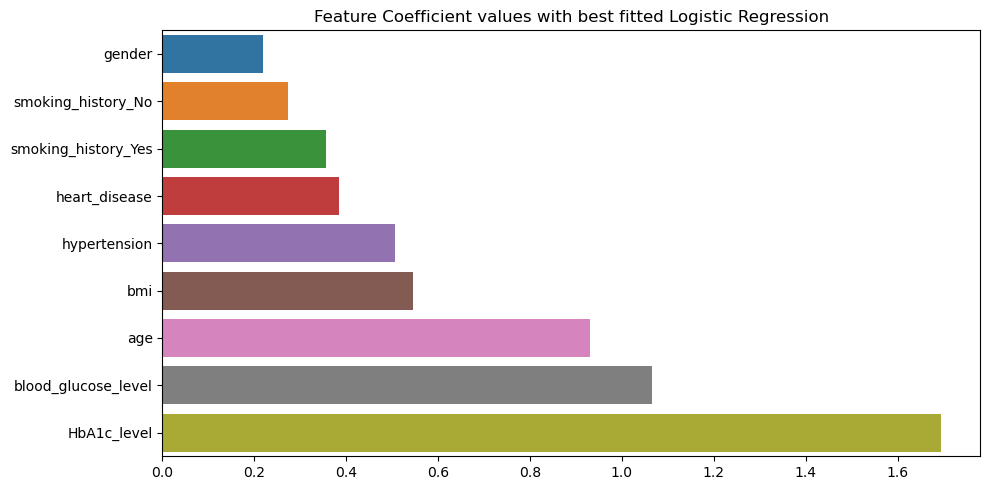

{'gender': 0.21986269603328507, 'smoking_history_No': 0.2728282348261961, 'smoking_history_Yes': 0.3561513849255352, 'heart_disease': 0.3846742425656496, 'hypertension': 0.5069621321680509, 'bmi': 0.544476116087239, 'age': 0.9312424339518869, 'blood_glucose_level': 1.0662681188521792, 'HbA1c_level': 1.6947679402495721}


In [75]:
plot_coefs_graph(lr_best, plot_title = "Feature Coefficient values with best fitted Logistic Regression")

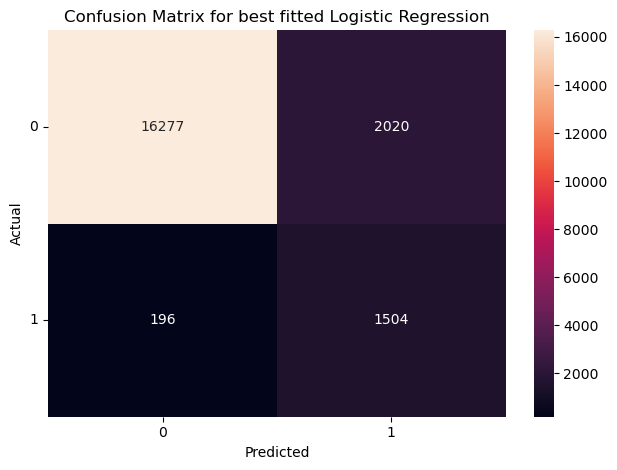

In [76]:
plot_CM(y_test, lr_best.predict(x_test_sohe), plot_title = "Confusion Matrix for best fitted Logistic Regression")

### SVM

Since the best fit SVM model uses a non-linear kernel (i.e. sigmoid kernel), we have to use other means to find the weight each feature has on the model.

We will be using a technique called permutation feature importance. The idea is to mix the values in each feature in the dataset. If it is important, then mixing the values will cause disruptions it has between other features, which would result in a drop in the model's performance.

In [77]:
perm_svm_train = permutation_importance(estimator = svm_best, X = x_train_sohe, y = y_train,
                                        scoring = "f1", sample_weight = [0.085 if y_val == 0 else 0.915 for y_val in y_train],
                                        random_state = 0)

perm_svm_test = permutation_importance(estimator = svm_best, X = x_test_sohe, y = y_test,
                                       scoring = "f1", sample_weight = [0.085 if y_val == 0 else 0.915 for y_val in y_test],
                                       random_state = 0)

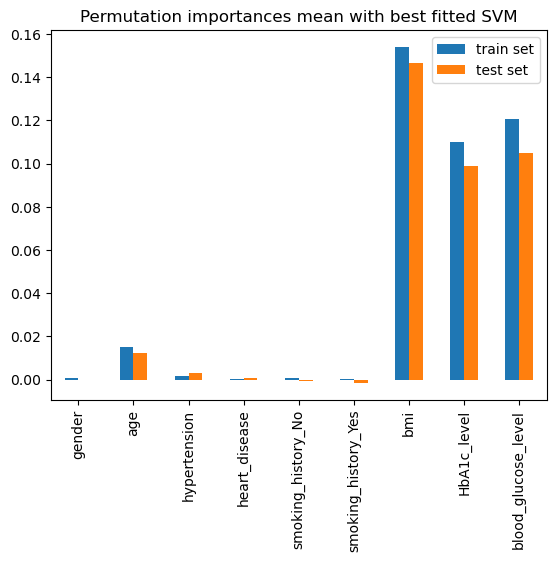


train importances mean: [0.00070012 0.01494821 0.00158498 0.00024851 0.00062424 0.00032186
 0.15410213 0.10981218 0.1207505 ]
test importances mean: [-0.00028109  0.01217124  0.00315835  0.00086931 -0.00085929 -0.00151331
  0.14662174  0.09910082  0.10483214]


In [78]:
plot_perm_importances_mean(perm_svm_train, perm_svm_test, list(x_train_sohe.columns), 
                           plot_title = "Permutation importances mean with best fitted SVM")

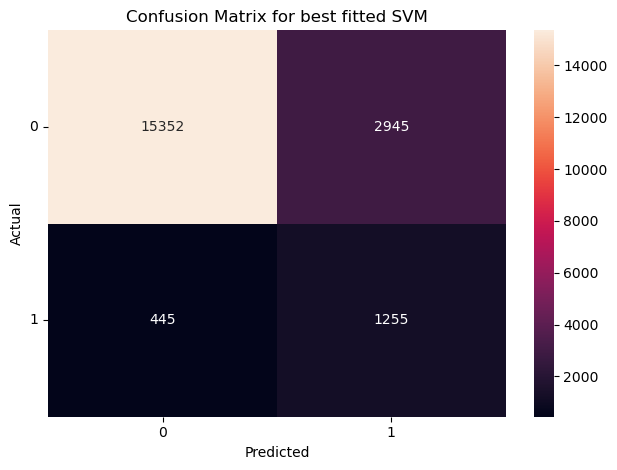

In [79]:
plot_CM(y_test, svm_best.predict(x_test_sohe), plot_title = "Confusion Matrix for best fitted SVM")

### Decision Tree

In [80]:
dot_data = tree.export_graphviz(dt_best, feature_names = x_train_ohe.columns,
                                rounded = True, precision = 2, filled = True)

# View in Jupyter Notebook
# display(graphviz.Source(dot_data))

# View in .png file
tree_graph = pydotplus.graph_from_dot_data(dot_data)
tree_graph.write_png("tree.png")

True

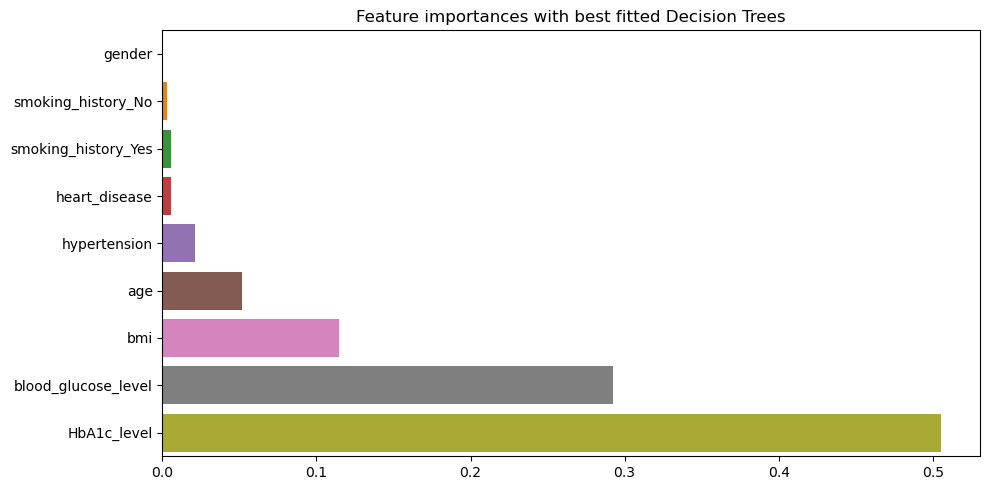

In [81]:
dt_best_feature_dict = {feature: feature_value for feature, feature_value in zip(dt_best.feature_names_in_, dt_best.feature_importances_)}
dt_best_feature_dict = dict(sorted(dt_best_feature_dict.items(), key = lambda x: x[1]))

features = list(dt_best_feature_dict.keys())
values = list(dt_best_feature_dict.values())

fig, ax = plt.subplots(figsize = (10, 5))

ax = sns.barplot(x = values, y = features, orient = "h")
ax.set(title = "Feature importances with best fitted Decision Trees")

plt.tight_layout()
plt.show()

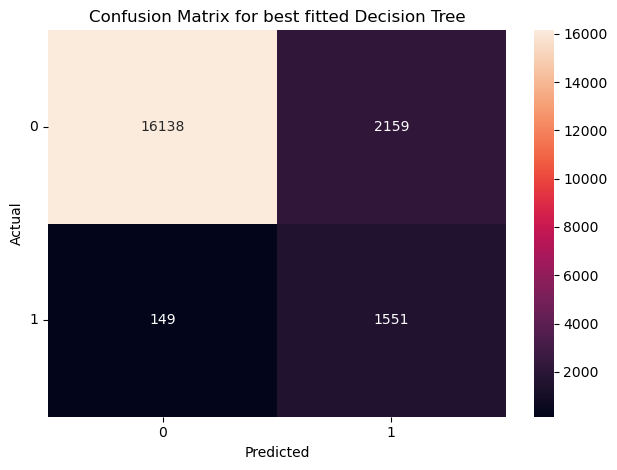

In [82]:
plot_CM(y_test, dt_best.predict(x_test_ohe), plot_title = "Confusion Matrix for best fitted Decision Tree")

- Logistic Regression
    - Based on feature coefficient values:
        - Order of feature importance (`Hemoglobin A1c level, blood glucose level, age, bmi, hypertension, heart disease, smoking history, gender`)
    - Based on confusion matrix
        - Logistic Regression was just short by 47 cases when matching positive diabetic cases when comparing to decision tree. It had the best in matching negative diabetic cases.
- SVM
    - Based on permutation importances mean:
        - Order of feature importance (`bmi, blood glucose level, Hemoglobin A1c level, age, hypertension, heart disease, gender, smoking history`)
    - Based on confusion matrix
        - SVM did the poorest, as it fails to match 445 positive diabetic cases. It also has the most number of False Positive cases (2945 FP cases)
    - Even though SVM had the least hyperparameters trained, it took the longest time to train
        - This is due to the dot product of every pair of data has to be calculated, and that gets more computationally expensive when we compare multiple kernels
- Decision Trees
    - Based on `tree.png`:
        - If a patient's `bmi` is more than 27.96, which is in the range of overweight (i.e. 25.0 to 30), they are likely to be diagnosed with `diabetes`
        - Having high values of `hemoglobin A1c` (6.7 or more) and `blood glucose level` (120 or more) are also signs of patients who may have been diagnosed with `diabetes`
        - Patients with `age` values past 50 (approximated) are also likely to be diagnosed with `diabetes`
    - Based on feature importances:
        - Order of feature importance (`Hemoglobin A1c level, blood glucose level, bmi, age, hypertension, heart disease, smoking history, gender`)
        - Features such as `HbA1c_level`, `blood_glucose_level`, `bmi` have a strong impact on the model in detecting cases of `diabetes`
        - Features such as `gender` and `smoking_history` do not have a significant impact
    - Based on confusion matrix
        - Decision Tree had the best result in matching positive diabetic cases. However, it is 139 cases short of predicting negative cases (which is not a lot when you take into account the number of negative diabetic data)

## Conclusion <a name = "conclusion"/>

Based on our analysis, we have found out that risk factors of diabetes include a hemoglobin A1c level at 6.7% or more, a blood glucose level at 120mg/dL or more, and a BMI of 27 and more. 

As for population demographics, diabetes is not linked to gender, but by age. As you age, your body becomes more resistant to insulin, a hormone produced by your pancreas that breaks down glucose. As a result, this makes it more diffcult to control blood sugar levels. This can be testified by the high hemoglobin A1c level and blood glucose level as seen in the analysis.

As with BMI, an overweight or obese person is likely to be diagnosed with diabetes. BMI is a measure of a person's body fat based on their height and weight. A high BMI usually shows an high body weight, which may be caused by poor dietary choices and a less active lifestyle. This also results in your body breaking down less glucose, which may ultimately lead to diabetes.

There has been little to address how hypertension, heart disease and having a past smoking history affect diabetes, but we do know that they cause stress in the body to break down glucose by developing a resistance to insulin.

With regard to model building and selection, we analysed model performance using roc-auc, precision, recall and f1 score. Decision Tree performed the best in terms of recall (i.e. less misclassifying on positive cases). When creating a machine, it is more important to isolate cases that are likely to be diagnosed with diabetes, even if it is not. Decision Tree also required less preprocessing as scaling is not required.

Logistic Regression did not fall far behind in performance metric and was the fastest to converge to a solution with the hyperparameters trained. It was also able to predict negative cases better than Decision Tree. However, SVM performed the worst. It took the longest to train, and was not able to provide results better than the other two. This may be due to the limited hyperparameters trained on SVM due to the context of time.

In conclusion, I will pick the Decision Tree as the main model, for predicting patients with diabetes.

### What's next?

- Data analysis
    - Analyse features such as hypertension, heart disease and smoking history with other medical features and how it affects or causes diabetes
- Model selection
    - Train more hyperparameters on SVM, if time is not a constraint
    - Decision Tree? Maybe make a better tree classifier? (e.g. Random Forest)
    - Or combine all 3 models and ensemble a multi-model model? (i.e. `StackingClassifier`)
- Using SHapley Additive exPlanations (SHAP)
    - SHAP is a more visually appealing model agnostic tool
    - It was not used in this lab as SVM models would take hours to generate the results